In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 1. load the clean

In [2]:
s3_filepath = 's3://datasets/kaggle/blastchar/telco-customer-churn/data.parquet'
df = pd.read_parquet(s3_filepath, storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
})
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
def df_info2(df):
    df_info = pd.DataFrame()
    df_info['dtype'] = df.dtypes
    df_info['#'] = df.count()
    df_info['#na'] = df.isna().sum()
    df_info['#unique'] = df.nunique()
    df_info['min'] = df.min()
    df_info['max'] = df.max()
    return df_info

In [4]:
# column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# column values
for c in df.dtypes[df.dtypes == 'object'].index:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
df_info2(df)

,dtype,#,#na,#unique,min,max
customerid,object,7043,0,7043,0002-orfbo,9995-hotoh
gender,object,7043,0,2,female,male
seniorcitizen,int64,7043,0,2,0,1
partner,object,7043,0,2,no,yes
dependents,object,7043,0,2,no,yes
tenure,int64,7043,0,73,0,72
phoneservice,object,7043,0,2,no,yes
multiplelines,object,7043,0,3,no,yes
internetservice,object,7043,0,3,dsl,no
onlinesecurity,object,7043,0,3,no,yes


In [6]:
df = df.drop('customerid', axis=1)

In [7]:
df.loc[(df.totalcharges == '_'), 'totalcharges'] = 0.0
df.totalcharges = df.totalcharges.fillna(0.0).astype('float')

In [8]:
df_info2(df)

,dtype,#,#na,#unique,min,max
gender,object,7043,0,2,female,male
seniorcitizen,int64,7043,0,2,0,1
partner,object,7043,0,2,no,yes
dependents,object,7043,0,2,no,yes
tenure,int64,7043,0,73,0,72
phoneservice,object,7043,0,2,no,yes
multiplelines,object,7043,0,3,no,yes
internetservice,object,7043,0,3,dsl,no
onlinesecurity,object,7043,0,3,no,yes
onlinebackup,object,7043,0,3,no,yes


In [9]:
def encode_boolean_types(df, cols, true_str='yes'):
    df[cols] = df[cols].apply(lambda series: (series == true_str).astype(int))
    return df

In [10]:
boolean_columns = []
for idx, row in df_info2(df).iterrows():
    if (row['dtype'], row['#unique'], row['max']) == ('object', 2, 'yes'):
        boolean_columns.append(idx)
df = encode_boolean_types(df, boolean_columns)

In [11]:
numerical_columns = ['tenure', 'monthlycharges', 'totalcharges']
obj_columns = []
for idx, val in df.dtypes.iteritems():
    if val == 'object':
        obj_columns.append(idx)

# 2. EDA

## 2.1 Feature importance

In [12]:
def show_mean_diff(df, col_base, col_others, ncols=3):
    rows = int(np.ceil(len(col_others) / ncols))
    fig, axes = plt.subplots(rows, ncols, figsize=(20,8))
    base_mean = df[col_base].mean()
    for i, col in enumerate(col_others):
        df_group = df.groupby(col).churn.agg(['mean'])
        df_group['diff'] = df_group['mean'] - base_mean
        df_group['risk'] = df_group['mean'] / base_mean
        colors = (df_group['diff'] >= 0).map({
            True: 'blue',
            False: 'red'
        })
        y = df_group.index
        ax = axes[i//ncols][i%ncols]
        ax.barh(y, df_group['diff'], color=colors)
        ax.set_xticks(np.linspace(-1, 1, 9))
        ax.set_title(col)
    fig.tight_layout()
    return fig, axes

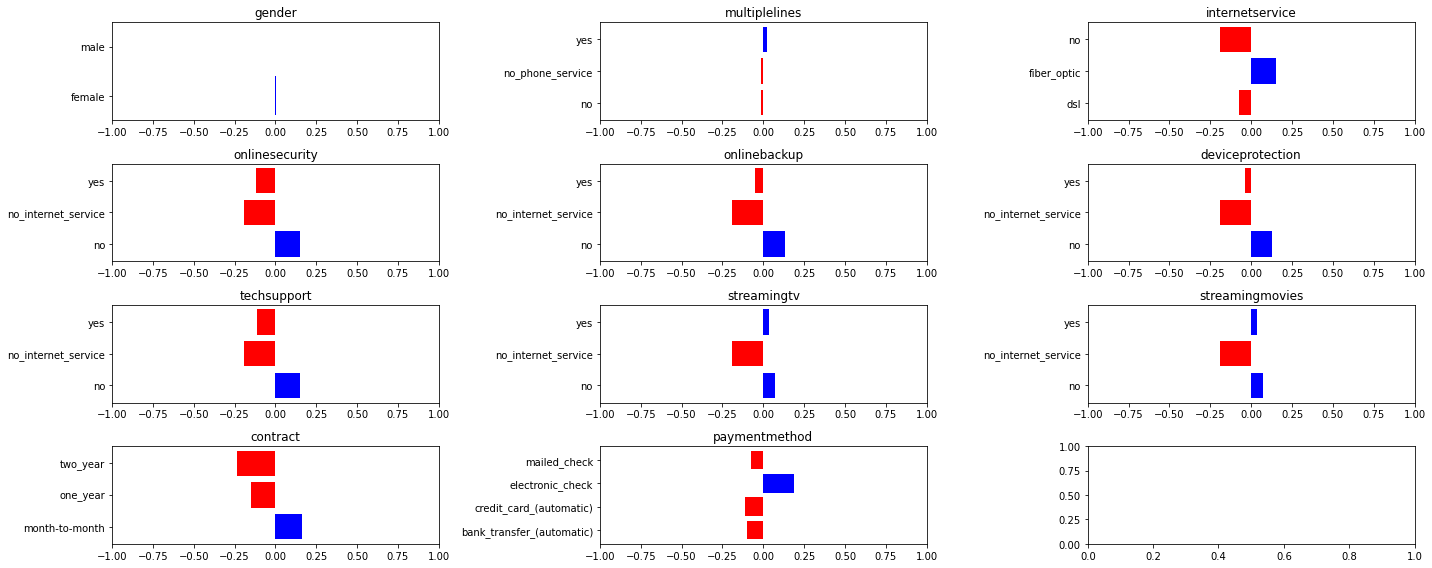

In [13]:
show_mean_diff(df, 'churn', obj_columns);

## 2.2 Mutual information

<AxesSubplot:>

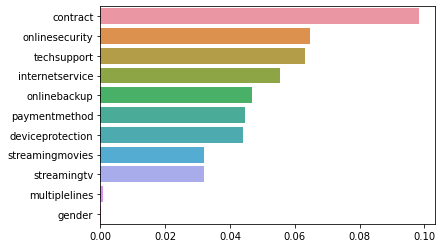

In [14]:
mi = df[obj_columns].apply(lambda series: (
    mutual_info_score(series, df['churn'])
)).sort_values(ascending=False)
sns.barplot(x=mi, y=mi.index)

## 2.3 Correlation

<AxesSubplot:>

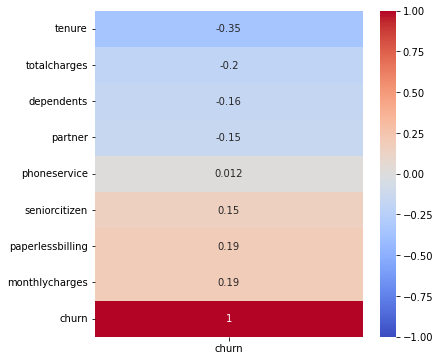

In [15]:
corr = df.corrwith(df['churn']).sort_values().to_frame('churn')
plt.figure(figsize=(6, 6))
cmap = sns.color_palette('coolwarm', as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, vmin=-1.0, vmax=1.0)

# 3. split data

In [16]:
# numerical_columns.remove('churn')

In [17]:
df_X = df.loc[:, df.columns != 'churn']
y = df['churn'].values

In [18]:
df_train, df_test, y_train, y_test = train_test_split(df_X, y, test_size=0.4)
df_val, df_test, y_val, y_test = train_test_split(df_test, y_test, test_size=0.5)

In [19]:
df_info2(df_train)

,dtype,#,#na,#unique,min,max
gender,object,4225,0,2,female,male
seniorcitizen,int64,4225,0,2,0,1
partner,int64,4225,0,2,0,1
dependents,int64,4225,0,2,0,1
tenure,int64,4225,0,73,0,72
phoneservice,int64,4225,0,2,0,1
multiplelines,object,4225,0,3,no,yes
internetservice,object,4225,0,3,dsl,no
onlinesecurity,object,4225,0,3,no,yes
onlinebackup,object,4225,0,3,no,yes


In [20]:
class ToDictTransformer(TransformerMixin):
    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        return df.to_dict(orient='records')

    def get_feature_names_out(self, df):
        return df.columns

In [21]:

clf = Pipeline(
    steps=[
        ('to_dict', ToDictTransformer()),
        ('vectorize', DictVectorizer(sparse=False)),
        ('scale', MinMaxScaler()),
        ('logistic', LogisticRegression(random_state=42, max_iter=500))
    ]
)

In [22]:
clf.fit(df_train, y_train)

Pipeline(steps=[('to_dict', <__main__.ToDictTransformer object at 0x2898e36d0>),
                ('vectorize', DictVectorizer(sparse=False)),
                ('scale', MinMaxScaler()),
                ('logistic',
                 LogisticRegression(max_iter=500, random_state=42))])

In [23]:
# dict(zip(clf[:-1].get_feature_names_out(df_train), clf._final_estimator.coef_[0]))

In [50]:
clf.score(df_val, y_val)

0.794889992902768

# Ch4

## 4.1 confusion matrix

In [62]:
def confusion_matrix(yhat, y):
    df = pd.DataFrame(columns=['p_n', 'p_p'])
    predict = [ (yhat == 0), (yhat == 1) ]
    actual = [ (y==0), (y==1) ]
    tp = predict[1] & actual[1]
    tn = predict[0] & actual[0]
    fp = predict[1] & actual[0]
    fn = predict[0] & actual[1]
    df.loc['a_n'] = [tn.sum(), fp.sum()]
    df.loc['a_p'] = [fn.sum(), tp.sum()]
    return df

In [101]:
def get_from_cm(cm, kind, ndigits=3):
    tn, fn = cm['p_n']
    fp, tp = cm['p_p']
    res = {
        'tp': lambda: tp,
        'tn': lambda: tn,
        'fp': lambda: fp,
        'fn': lambda: fn,
        'precision': lambda: tp / (tp + fp),
        'recall': lambda: tp / (tp + fn),
        'tpr': lambda: tp / (tp + fn),
        'fpr': lambda: fp / (fp + tn),
        'accuracy': lambda: (tp + tn) / (tp + tn + fp + fn),
        'default': lambda: 0.0
    }.get(kind, 'default')()
    return round(res, ndigits)

In [150]:
yhat = clf.predict_proba(df_val)[:, 1]

In [74]:
cm = confusion_matrix(yhat >= 0.5, y_val)
cm

,p_n,p_p
a_n,909,110
a_p,179,211


In [75]:
precision = get_from_cm(cm, 'precision')
recall = get_from_cm(cm, 'recall')
accuracy = get_from_cm(cm, 'accuracy')
precision, recall, accuracy

(0.657, 0.541, 0.795)

In [97]:
np.linspace(0, 1, 2)

array([0., 1.])

In [137]:
def sample_tpr_fpr(yhat, y, size=101):
    thresholds = np.linspace(0, 1, size)
    scores = []
    df = pd.DataFrame(columns=['tpr', 'fpr'])
    for t in thresholds:
        cm = confusion_matrix(yhat >= t, y)
        df.loc[t] = [
            get_from_cm(cm, 'tpr'),
            get_from_cm(cm, 'fpr'),
        ]
    df = df.rename_axis('threshold')
    return df

In [193]:
def plot_trp_fpr(df, prefix=''):
    ax = sns.lineplot(x=df.index, y='tpr', data=df, label=f'{prefix}TPR')
    sns.lineplot(x=df.index, y='fpr', data=df, label=f'{prefix}FPR')
    plt.gca().set_ylabel('')


In [201]:
df_scores = sample_tpr_fpr(yhat, y_val, 201)

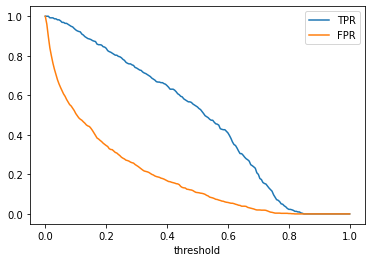

In [202]:
plot_trp_fpr(df_scores)

our goal is to make tpr as larger as possible while fpr as smaller as possible.

Random model

In [203]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [204]:
((y_rand >= 0.5) == y_val).mean()

0.5003548616039745

In [206]:
df_rand_scores = sample_tpr_fpr(y_rand, y_val, 201)

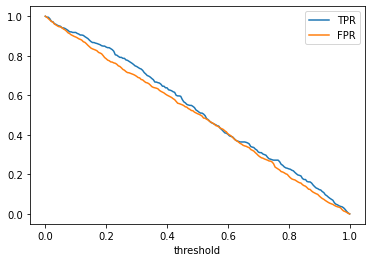

In [207]:
plot_trp_fpr(df_rand_scores)

Ideal model

In [153]:
y_ideal = np.repeat([0, 1], [(y_val == 0).sum(), (y_val == 1).sum()])

In [154]:
y_ideal_hat = np.linspace(0, 1, len(y_val))

In [157]:
1 - y_val.mean()

0.723207948899929

In [172]:
((y_ideal_hat >= 0.7232) == y_ideal).mean()

1.0

In [209]:
df_ideal_scores = sample_tpr_fpr(y_ideal_hat, y_ideal, 201)

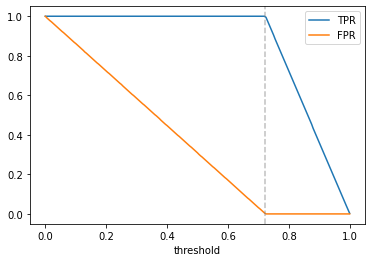

In [210]:
plot_trp_fpr(df_ideal_scores)
plt.axvline(1-y_val.mean(), linestyle='--', alpha=0.5, color='gray')

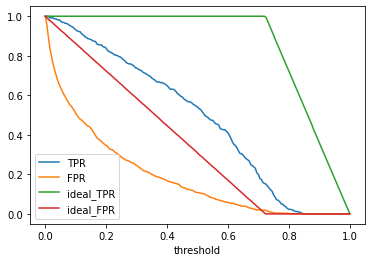

In [211]:
plot_trp_fpr(df_scores)
plot_trp_fpr(df_ideal_scores, prefix='ideal_')

<AxesSubplot:xlabel='fpr', ylabel='tpr'>

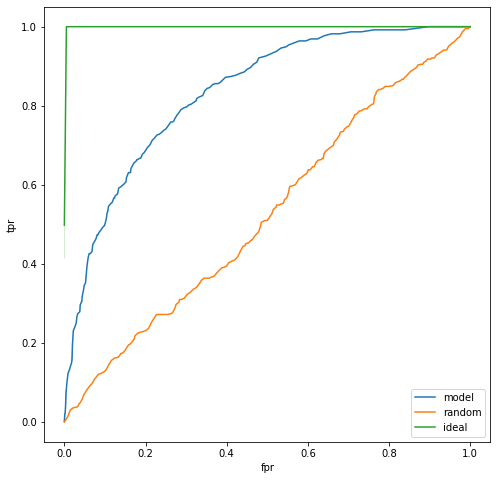

In [219]:
plt.figure(figsize=(8,8))
sns.lineplot(x=df_scores.fpr, y=df_scores.tpr, label='model')
sns.lineplot(x=df_rand_scores.fpr, y=df_rand_scores.tpr, label='random')
sns.lineplot(x=df_ideal_scores.fpr, y=df_ideal_scores.tpr, label='ideal')
# plt.plot(df_ideal_scores.fpr, df_ideal_scores.tpr, label='model')

don't know why seaborn don't finishing the gree line while matplotlib plot can.

our model(blue line) should reside between the other 2 lines, the closer to the top left corner the better

if our model appear under the yellow line, that indicate there must have same error in the model.

In [233]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [221]:
fpr, tpr, thresholds = roc_curve(y_val, yhat)

Text(0.5, 0, 'FPR')

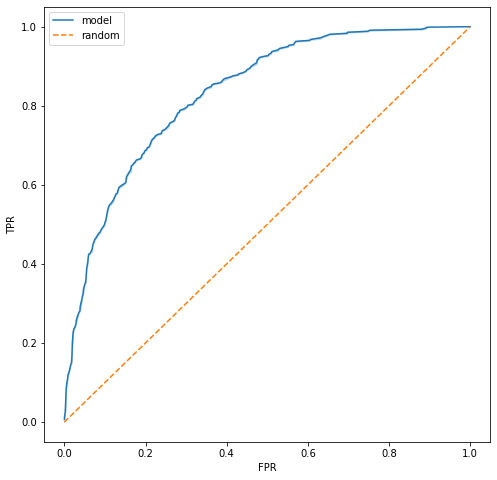

In [224]:
plt.figure(figsize=(8,8))
sns.lineplot(x=fpr, y=tpr, label='model')
sns.lineplot(x=[0, 1], y=[0, 1], label='random', linestyle='--')
plt.ylabel('TPR')
plt.xlabel('FPR')

In [234]:
auc(fpr, tpr)

0.8328426561988878

AUC interpretation

the probability for randomly select 2 examples, 1 from positive and 1 from negative that the prob of positive is greater than the prob of negative.

maybe a sample code can explain better.

In [249]:
n = 10000
pos = yhat[y_val == 1]
neg = yhat[y_val == 0]
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)
(pos[pos_idx] > neg[neg_idx]).mean()

0.8257